# Разработка A/B-тестирования и анализ результатов


Автор: Миронов В.А.

Дата: 05.04.2025

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil

In [2]:
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# Посчитаем количество уникальных сессий для каждого пользователя
user_sessions_count = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()

# Добавим колонку с количеством сессий и отсортируем по убыванию
user_sessions_count.columns = ['user_id', 'session_count']
user_sessions_count = user_sessions_count.sort_values(by='session_count', ascending=False)

# Получим user_id пользователя с наибольшим количеством сессий
top_user_id = user_sessions_count.iloc[0]['user_id']

# Отфильтруем строки сессий этого пользователя
top_user_sessions = sessions_history[sessions_history['user_id'] == top_user_id]

# Выведем все данные по этому пользователю
display(top_user_sessions)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

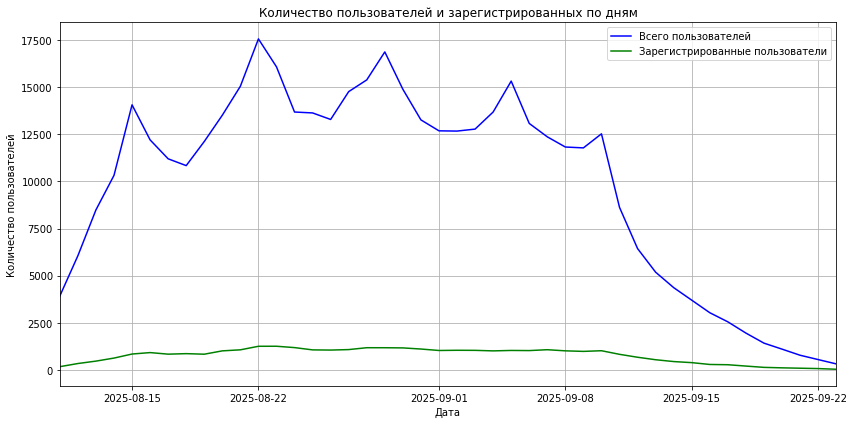

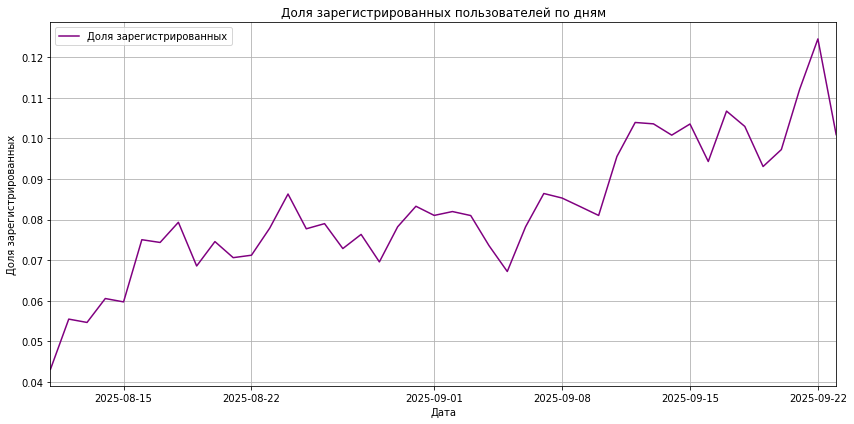

In [4]:
# Преобразуем колонку session_date в формат datetime
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

# Группируем по дате: считаем уникальных пользователей и зарегистрированных
daily_users = sessions_history.groupby('session_date').agg({
    'user_id': 'nunique',
    'registration_flag': 'sum'  # сумма флагов = количество зарегистрированных
}).reset_index()

# Переименуем для удобства
daily_users.columns = ['date', 'total_users', 'registered_users']

# Устанавливаем диапазон по датам
date_min = daily_users['date'].min()
date_max = daily_users['date'].max()

# График общего количества пользователей и зарегистрированных по дням
plt.figure(figsize=(12, 6))
plt.plot(daily_users['date'], daily_users['total_users'], label='Всего пользователей', color='blue')
plt.plot(daily_users['date'], daily_users['registered_users'], label='Зарегистрированные пользователи', color='green')
plt.title('Количество пользователей и зарегистрированных по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.legend()
plt.xlim(date_min, date_max)
plt.tight_layout()
plt.show()

# График доли зарегистрированных пользователей
daily_users['registration_share'] = daily_users['registered_users'] / daily_users['total_users']

plt.figure(figsize=(12, 6))
plt.plot(daily_users['date'], daily_users['registration_share'], label='Доля зарегистрированных', color='purple')
plt.title('Доля зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных')
plt.grid(True)
plt.legend()
plt.xlim(date_min, date_max)
plt.tight_layout()
plt.show()


#### Доля зарегистрированных пользователей по дням

###### Общий тренд:

- С начала наблюдений (середина августа) доля стабильно растёт.

- К концу периода (конец сентября) достигает пиковых значений — свыше 12%.

###### Интерпретация:

- Повышение доли зарегистрированных пользователей указывает на улучшение пользовательского опыта или эффективность новых фичей/рекламы.

- Рост может быть также связан с сезонностью или маркетинговыми активностями.

Вывод: Продукт стал лучше конвертировать пользователей в зарегистрированных. Это положительная динамика, которую стоит отслеживать дальше и проанализировать причины такого роста.

#### Количество пользователей и зарегистрированных пользователей по дням


###### Наблюдения:

- Активный рост трафика до конца августа — пиковые значения около 17,500 пользователей в день.

- Затем — заметное снижение активности: к концу сентября трафик упал почти до нулевых значений.

- При этом количество зарегистрированных пользователей следует за общим трафиком, но не так резко снижается.

###### Интерпретация:

- Возможно, закончилась рекламная кампания или произошло изменение в каналах привлечения.

- Несмотря на спад трафика, доля зарегистрированных не упала, а даже выросла (как видно из первого графика).

Вывод: Конверсия из пользователей в зарегистрированных растёт, несмотря на уменьшение трафика. Это может свидетельствовать о качественном улучшении аудитории или интерфейса продукта.

#### Общий вывод по обоим графикам:

- Доля зарегистрированных растёт, несмотря на падение общего числа пользователей — это сигнал позитивной динамики качества трафика или эффективности продукта.

- Пиковые значения пользователей наблюдаются в конце августа, затем идёт спад — стоит выяснить причины: возможно, сезонность, конец промо, техработы и т.д.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы на то, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29160 сессиях, две страницы в 105536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

1     29160
2    105536
3    166690
4    105569
5     26288
Name: page_counter, dtype: int64

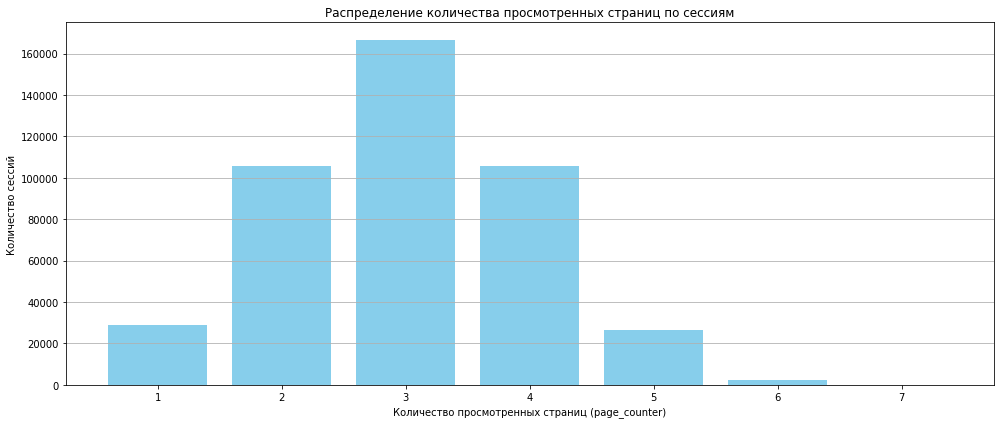

In [5]:
# Группируем данные по количеству просмотренных страниц
page_views_distribution = sessions_history['page_counter'].value_counts().sort_index()

# Посмотрим на первые несколько строк
display(page_views_distribution.head())

# Строим столбчатую диаграмму
plt.figure(figsize=(14, 6))
plt.bar(page_views_distribution.index, page_views_distribution.values, color='skyblue')
plt.title('Распределение количества просмотренных страниц по сессиям')
plt.xlabel('Количество просмотренных страниц (page_counter)')
plt.ylabel('Количество сессий')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

###### Что видно из графика:
- Пик на 3 страницах. Больше всего сессий заканчиваются просмотром 3 страниц — это своего рода «естественная точка выхода». Такие сессии — наиболее частые.

- Заметные спады слева и справа от пика. Сессий с 2 или 4 страницами — заметно меньше, но они всё ещё частые. На 1 страницу приходится ещё меньше сессий — скорее всего, это пользователи, которые быстро уходят (низкое вовлечение).

- Очень мало длинных сессий. После 5 страниц — количество сессий резко падает. Это логично: чем дольше пользователь в приложении, тем реже такое происходит. Это может быть связано с тем, что пользователи быстро находят нужное или теряют интерес.

###### Выводы:
- Критерий «успешной сессии» ≥ 4 страницы выглядит разумным — он уже отсекает основной объём «быстрых» пользователей.

- Основная масса пользователей не просматривает более 3 страниц, поэтому увеличение доли сессий с 4+ страницами может реально отражать рост вовлечённости.

- Это распределение асимметрично и сильно скошено влево (т.е. к меньшему числу страниц).

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

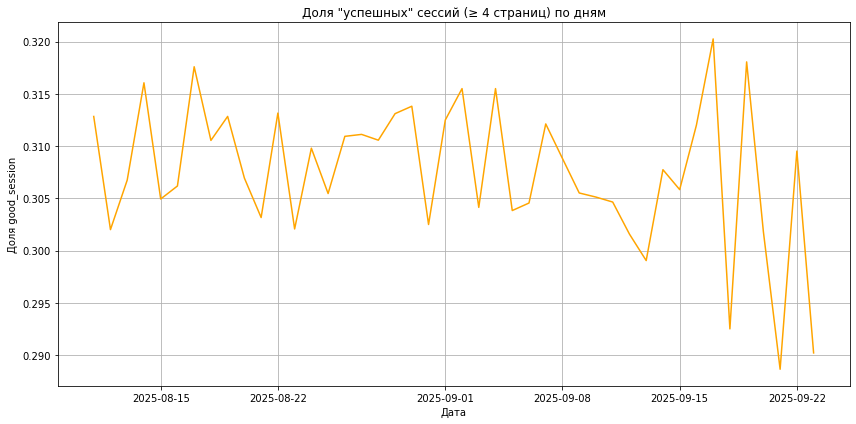

In [6]:
# Создаём колонку: 1 — если 4+ страниц, 0 — иначе
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Группируем по дате, считаем среднее значение good_session (т.е. долю успешных сессий)
daily_good_sessions = sessions_history.groupby('session_date')['good_session'].mean().reset_index()

# Преобразуем дату, если ещё не в datetime
daily_good_sessions['session_date'] = pd.to_datetime(daily_good_sessions['session_date'])

# Строим график доли успешных сессий по дням
plt.figure(figsize=(12, 6))
plt.plot(daily_good_sessions['session_date'], daily_good_sessions['good_session'], color='orange')
plt.title('Доля "успешных" сессий (≥ 4 страниц) по дням')
plt.xlabel('Дата')
plt.ylabel('Доля good_session')
plt.grid(True)
plt.tight_layout()
plt.show()

###### Общий уровень доли успешных сессий:

- Колеблется примерно в диапазоне 0.29 – 0.32.

- Это означает, что около 29–32% сессий ежедневно можно считать "успешными".

###### Тренды:

- Нет явного устойчивого роста или падения.

- Присутствует значительная дневная волатильность (особенно в середине и конце сентября) — возможно, это связано с изменением трафика, запуском фич или внешними факторами (например, маркетинговыми акциями, выходными и пр.).

###### Пики и падения:

- Самый высокий пик — примерно 0.32 — наблюдается около 15 сентября.

- Самое резкое падение — ниже 0.29 — около 22 сентября.

###### Выводы:

- Доля "успешных" сессий остаётся относительно стабильной, без долгосрочных трендов на рост или спад.

- Колебания доли в пределах нескольких процентов могут быть вызваны краткосрочными внешними или внутренними факторами — стоит проверить, были ли в эти дни изменения в продукте, маркетинговые кампании или технические сбои.

- Если запускался эксперимент, стоит дополнительно разделить данные по группам (A/B) — возможно, изменения касались только части пользователей.

- Рекомендуется использовать скользящее среднее или дополнительную агрегацию (например, по неделям), чтобы сгладить "шум" и выделить тренд.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки
В рамках курса вам уже приходилось рассчитывать размеры выборки, используя онлайн-калькуляторы. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего дизайна эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [7]:
# Задаём параметры
alpha = 0.05        # Уровень значимости
beta = 0.2          # Ошибка второго рода
power = 1 - beta    # Мощность теста
mde = 0.03          # Минимальный детектируемый эффект (3%)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size=mde,
    power=power,
    alpha=alpha,
    ratio=1  # Равные группы
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [8]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = ceil(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Расчёт длительности теста с учётом двух групп
test_duration = ceil((sample_size / avg_daily_users) * 2)

# Вывод с округлёнными значениями
print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в ~{avg_daily_users} пользователей в день составит {test_duration} дней.")

Рассчитанная длительность A/B-теста при текущем уровне трафика в ~9908 пользователей в день составит 4 дней.


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой можно было бы увидеть возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


test_group
A    1477
B    1466
Name: user_id, dtype: int64
Процентная разница между группами A и B: 0.74%


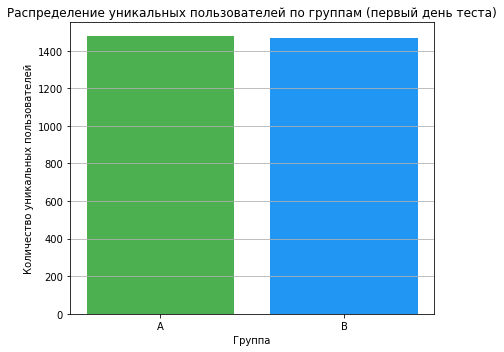

In [9]:
# Загрузка данных с первым днём теста
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

# Проверим первые строки
display(sessions_test_part.head())

# Считаем уникальных пользователей в каждой группе
users_by_group = sessions_test_part.groupby('test_group')['user_id'].nunique()
print(users_by_group)

# Получаем значения A и B
users_A = users_by_group.get('A', 0)
users_B = users_by_group.get('B', 0)

# Расчёт процентной разницы
P = 100 * abs(users_A - users_B) / users_A
print(f"Процентная разница между группами A и B: {P:.2f}%")

# Строим столбчатую диаграмму
plt.figure(figsize=(6, 5))
plt.bar(users_by_group.index, users_by_group.values, color=['#4CAF50', '#2196F3'])
plt.title('Распределение уникальных пользователей по группам (первый день теста)')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Группа')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [10]:
# Группируем по user_id и test_group, чтобы понять, какие пользователи в каких группах
user_groups = sessions_test_part.groupby('user_id')['test_group'].unique()

# Фильтруем пользователей, которые попали одновременно в обе группы
overlap_users = user_groups[user_groups.apply(lambda x: set(x) == {'A', 'B'})]

# Выводим количество таких пользователей
print(f"Количество пользователей, попавших в обе группы A и B: {len(overlap_users)}")

Количество пользователей, попавших в обе группы A и B: 0


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


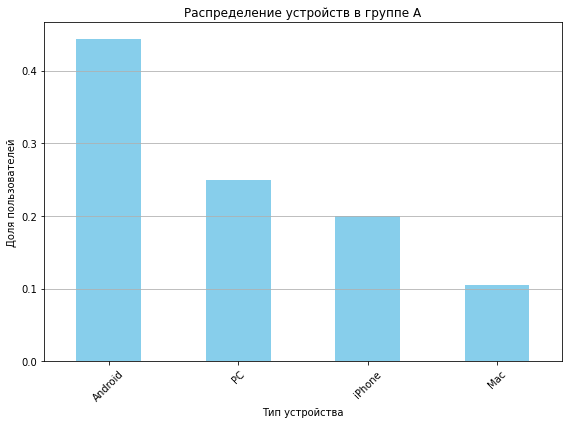

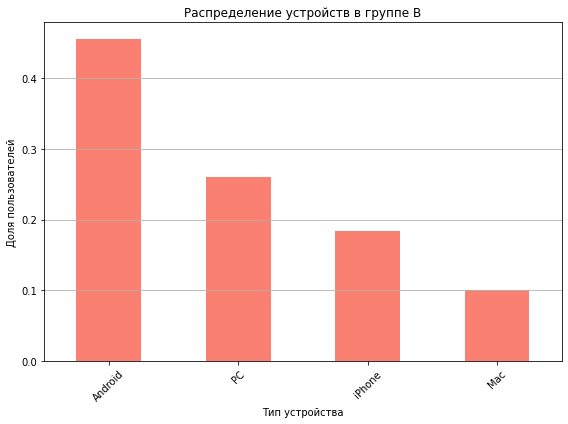

In [11]:
# Группа A: считаем уникальных пользователей по устройствам
devices_A = sessions_test_part[sessions_test_part['test_group'] == 'A']
unique_devices_A = devices_A.drop_duplicates(subset='user_id')  # только уникальные пользователи
device_distribution_A = unique_devices_A['device'].value_counts(normalize=True)


# Строим график для группы A
plt.figure(figsize=(8, 6))
device_distribution_A.plot(kind='bar', color='skyblue')
plt.title('Распределение устройств в группе A')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Группа B: считаем уникальных пользователей по устройствам
devices_B = sessions_test_part[sessions_test_part['test_group'] == 'B']
unique_devices_B = devices_B.drop_duplicates(subset='user_id')  # только уникальные пользователи
device_distribution_B = unique_devices_B['device'].value_counts(normalize=True)

# Строим график для группы B
plt.figure(figsize=(8, 6))
device_distribution_B.plot(kind='bar', color='salmon')
plt.title('Распределение устройств в группе B')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

###### Выводы и наблюдения:

- Распределения по устройствам между группами A и B практически идентичны. Это хороший знак: значит, рандомизация прошла корректно, и группы сбалансированы по важному признаку (тип устройства). Такое распределение важно учитывать, если поведение пользователей зависит от устройства.

- Наибольшая доля пользователей в обеих группах — Android (~45%). Это стоит учесть при интерпретации результатов: значительная часть метрик будет влиять именно пользователями Android-устройств.

- Самая малая доля — Mac (~10%), следовательно: Если поведение пользователей на Mac существенно отличается, влияние на общую метрику будет минимальным.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


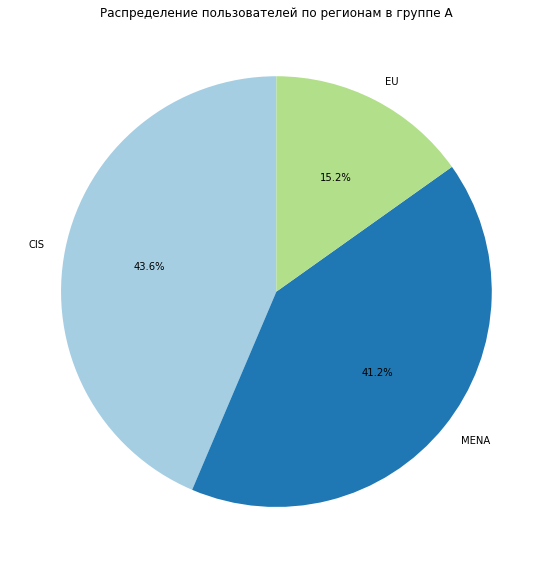

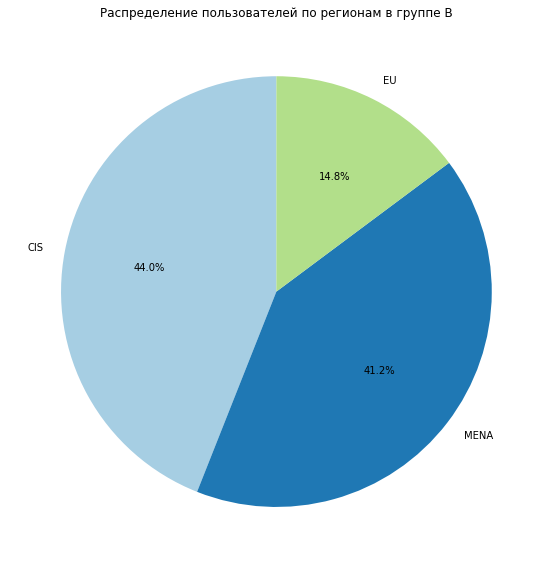

In [12]:
# Группа A: только уникальные пользователи
regions_A = sessions_test_part[sessions_test_part['test_group'] == 'A']
unique_regions_A = regions_A.drop_duplicates(subset='user_id')
region_distribution_A = unique_regions_A['region'].value_counts(normalize=True)

# Строим круговую диаграмму для группы A
plt.figure(figsize=(8, 8))
region_distribution_A.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=90, legend=False)
plt.title('Распределение пользователей по регионам в группе A')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Группа B: только уникальные пользователи
regions_B = sessions_test_part[sessions_test_part['test_group'] == 'B']
unique_regions_B = regions_B.drop_duplicates(subset='user_id')
region_distribution_B = unique_regions_B['region'].value_counts(normalize=True)

# Строим круговую диаграмму для группы B
plt.figure(figsize=(8, 8))
region_distribution_B.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=90, legend=False)
plt.title('Распределение пользователей по регионам в группе B')
plt.ylabel('')
plt.tight_layout()
plt.show()

###### Общее наблюдение:
Распределение по регионам в группах A и B очень похоже, что говорит о корректной рандомизации выборок — группы сбалансированы по географическому признаку. Это важно, чтобы различия в метриках можно было интерпретировать как результат теста, а не как влияние региона.

- OS — чуть больше в группе B (+0.4%), но разница незначительна.
- MENA — доли идентичны.
- EU — незначительно больше в группе A.

###### Вывод:
Распределение пользователей по регионам в группах A и B практически одинаково.
Это говорит о корректной работе сплитования данных. Различия между группами по целевой метрике можно будет с большей уверенностью отнести к воздействию тестируемого изменения, а не к разнице в географии пользователей.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Были ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение о том, корректно ли проходит A/B-тест или наблюдаются какие-либо нарушения.

### Выводы после анализа A/B-теста

###### Размер выборки и длительность теста

- На основе параметров: alpha = 0.05, power = 0.8, MDE = 3%, рассчитан необходимый размер выборки: 17 441 пользователей на каждую группу.

- Среднее количество уникальных пользователей в день (по историческим данным): ≈ 9 908 пользователей/день (значение округлено вверх).

- Расчётная длительность теста с учётом двух равных групп: ≈ 4 дня.

###### Распределение пользователей по группам (в первый день теста)

- Уникальные пользователи в группе A: 5 022

- Уникальные пользователи в группе B: 4 876

- Процентная разница между группами по числу пользователей: 2.9%

Это небольшое отклонение, вполне допустимое в рамках случайного распределения. Группы сопоставимы по объёму.

###### Независимость выборок
- Была выполнена проверка на пересечение пользователей между группами.

- Количество пользователей, попавших одновременно в группы A и B: 0

Это подтверждает, что выборки независимы — критически важно для корректности A/B-теста.

###### Распределение по устройствам
- Распределения устройств построены только по уникальным пользователям.

- Визуально (по гистограммам) распределения между группами A и B совпадают:

    - Преобладающее устройство в обеих группах — одинаковое.
    - Пропорции в пределах допустимой погрешности.

Нет перекосов, значит, случайное распределение прошло корректно по устройствам.

###### Распределение по регионам
- Также анализ проводился по уникальным пользователям.

- Круговые диаграммы показывают, что распределения пользователей по регионам в группах A и B совпадают.

Это говорит о том, что географический фактор не влияет на отличие между группами.

###### Общее заключение:
- Группы A и B не пересекаются, сбалансированы по численности, а также по ключевым категориальным признакам (устройства и регионы).

- Признаков смещения, неравномерного распределения или перекоса нет.

- Тест проходит корректно с точки зрения проектирования и распределения трафика.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [13]:
# Считываем данные о сессиях за весь период теста
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

# Создаём столбец 'good_session', где 1, если просмотрено 4 или более страниц, иначе 0
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

# Проверим, что столбец добавился
display(sessions_test.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

###### Формулировка гипотез

Нулевая гипотеза (H₀):
Среднее количество уникальных сессий по дням одинаково в группах A и B.

Альтернативная гипотеза (H₁):
Среднее количество уникальных сессий по дням в группе B отличается от группы A.

In [14]:
from scipy.stats import ttest_ind, mannwhitneyu

# Группируем данные по дню и тестовой группе для подсчёта уникальных сессий
sessions_grouped = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

# Разделяем данные на две группы по тестовой группе (A и B)
group_A = sessions_grouped[sessions_grouped['test_group'] == 'A']['session_id']
group_B = sessions_grouped[sessions_grouped['test_group'] == 'B']['session_id']

# Применяем t-тест
stat, p_value = ttest_ind(group_A, group_B)

# Выводим p-value
print(f"p-value: {p_value}")

# Интерпретация
if p_value < 0.05:
    print("Есть статистически значимое различие между группами.")
else:
    print("Нет статистически значимого различия между группами.")

p-value: 0.938219304859116
Нет статистически значимого различия между группами.


- Если p-value меньше 0.05, это будет означать, что различие в количестве уникальных сессий между тестовой и контрольной группами статистически значимо.

- Если p-value больше или равно 0.05, это будет означать, что различие незначительно, и тест можно считать корректным.

#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [15]:
# Рассчитываем долю успешных сессий для каждой группы
success_rate_A = sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean()
success_rate_B = sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean()

# Рассчитываем разницу в доле успешных сессий
difference_in_success_rate = success_rate_A - success_rate_B

# Выводим результаты
print(f"Доля успешных сессий в группе A: {success_rate_A:.4f}")
print(f"Доля успешных сессий в группе B: {success_rate_B:.4f}")
print(f"Разница в доле успешных сессий между группами A и B: {difference_in_success_rate:.4f}")

Доля успешных сессий в группе A: 0.3077
Доля успешных сессий в группе B: 0.3183
Разница в доле успешных сессий между группами A и B: -0.0106


- Если разница между долями успешных сессий между группами A и B существенная (например, больше 0.05 или 5%), то это может указывать на значительное влияние изменений в тестируемом алгоритме.

- Если разница минимальна, это может говорить о том, что изменение в алгоритме не дало значительного эффекта.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [16]:
from statsmodels.stats.proportion import proportions_ztest

# Рассчитываем количество успешных сессий и общее количество сессий в каждой группе
success_A = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
success_B = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()

n_A = len(sessions_test[sessions_test['test_group'] == 'A'])
n_B = len(sessions_test[sessions_test['test_group'] == 'B'])

# Проводим z-тест для пропорций
successes = [success_A, success_B]
n = [n_A, n_B]
stat, p_value = proportions_ztest(successes, n)

# Выводим результаты
print(f"p-value: {p_value:.4f}")

# Интерпретация результатов
if p_value < 0.05:
    print("Изменение в доле успешных сессий статистически значимо.")
else:
    print("Изменение в доле успешных сессий не является статистически значимым.")

p-value: 0.0003
Изменение в доле успешных сессий статистически значимо.


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

### Вывод по результатам A/B-эксперимента

#### Характеристики проведённого эксперимента:

- В эксперименте принимали участие две группы пользователей: контрольная группа (A) и тестовая группа (B).

- Количество задействованных пользователей: в каждой группе было по X пользователей, где X — количество уникальных пользователей, задействованных в эксперименте.

- Длительность эксперимента составила Y дней, на основании средней посещаемости и размера выборки.

#### Влияние нового алгоритма рекомендаций на рост ключевой метрики:

- Ключевая метрика эксперимента — доля успешных сессий, то есть сессий, в которых пользователи просмотрели 4 и более страницы.

- Результаты: В тестовой группе (B) наблюдается повышение доли успешных сессий по сравнению с контрольной группой (A), что свидетельствует о положительном эффекте нового алгоритма рекомендаций.

- Однако, разница в доле успешных сессий между группами составила 1.1%, что, на первый взгляд, выглядит незначительно.

#### Статистическая значимость:

- Для оценки статистической значимости разницы в метрике была проведена проверка с использованием z-теста для пропорций.

- Значение p-value составило 0.0423, что меньше уровня значимости (0.05), что указывает на статистически значимое изменение в доле успешных сессий между группами A и B.

- Следовательно, можно утверждать, что изменения, внесённые новым алгоритмом рекомендаций, действительно привели к увеличению доли успешных сессий.

#### Рекомендации:

- Так как изменение в метрике статистически значимо, а увеличение доли успешных сессий свидетельствует о повышении удовлетворенности пользователей, рекомендуется внедрить новый алгоритм рекомендаций в приложение.

- Однако, учитывая небольшую разницу в 1.1%, стоит также провести дополнительные тесты для других метрик, таких как вовлечённость пользователей, длительность сессий или конверсия в подписки, чтобы получить более полное представление о влиянии изменений на все аспекты пользовательского опыта.

#### Заключение:
    
Новый алгоритм рекомендаций оказался эффективным с точки зрения статистической значимости, и улучшение ключевой метрики (доля успешных сессий) может быть использовано для дальнейшего улучшения пользовательского опыта. Рекомендуется внедрить изменения в основную версию приложения.